In [1]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import Affine
from rasterio.enums import Resampling
from rasterstats import point_query
import earthpy.plot as ep
from scipy import ndimage, stats
import matplotlib.pyplot as plt
import plotly.express as px

In [25]:
# Directories and Source Files
work_dir = '/Users/arbailey/natcap/idb/data/work/sentinel'
tile = 'T16QDF'
# Relative bathy rasters for the blue/red and blue/green ratios
rb_red_file = tile + '_relbathy_red.tif' # "relbathy_red.vrt" #
rb_grn_file = tile + '_relbathy_grn.tif' # "relbathy_grn.vrt" #
rb_red_source = os.path.join(work_dir, rb_red_file)
rb_grn_source = os.path.join(work_dir, rb_grn_file)

# depth points  for Relative to Absolute bathymetry tuning
# AGRRA  (yes, I mispelled the shapefile)
aggrapts_shp = "aggra_Site_2020_32616.shp"
aggrapts_dir = "/Users/arbailey/natcap/idb/data/work/bathy/"
depthpts_path = os.path.join(aggrapts_dir, aggrapts_shp)
pt_depth = "MeanDep"
# Soundings
soundings_shp = "soundings_subset" + tile + "_32616.shp"
soundings_shp = "soundings_subsetCmap_32616.shp"
soundings_dir = "/Users/arbailey/natcap/idb/data/work/sentinel/"
depthpts_path = os.path.join(soundings_dir, soundings_shp)
pt_depth = "dep_m"

# output_points_shp = "sample_pts" + tile + "_32616.shp"
# output_points_path = os.path.join(work_dir, output_points_shp)

In [3]:
# Import Relative Bathy rasters with rasterio
print(rb_red_source)
with rasterio.open(rb_red_source) as src:
    rb_red_profile = src.profile
    rb_red_np = src.read(1)
    print(rb_red_np)
    print(rb_red_profile)
    
print(rb_grn_source)
with rasterio.open(rb_grn_source) as src:
    rb_grn_profile = src.profile
    rb_grn_np = src.read(1)
    print(rb_grn_np)
    print(rb_grn_profile)

/Users/arbailey/natcap/idb/data/work/sentinel/T16QDF_relbathy_red.tif
[[-9.9990000e+03 -9.9990000e+03 -9.9990000e+03 ...  1.0444647e+00
   1.0403126e+00  9.1482437e-01]
 [-9.9990000e+03 -9.9990000e+03 -9.9990000e+03 ...  1.0078201e+00
   1.0787100e+00  1.0442038e+00]
 [-9.9990000e+03 -9.9990000e+03  8.6362314e-01 ...  1.0505912e+00
   1.1571628e+00  1.1571826e+00]
 ...
 [-9.9990000e+03 -9.9990000e+03 -9.9990000e+03 ...  1.0159725e+00
   1.0216410e+00  1.0777298e+00]
 [-9.9990000e+03 -9.9990000e+03 -9.9990000e+03 ...  1.0703115e+00
   1.1426219e+00  1.1769999e+00]
 [-9.9990000e+03 -9.9990000e+03 -9.9990000e+03 ...  1.0754999e+00
   1.0418037e+00  1.0737711e+00]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 2100000.0), 'tiled': False, 'interleave': 'band'}
/Users/arbailey/natcap/idb/data/work/sentinel/T16QDF_relbathy_grn.tif
[[-9.9990000e+03 

In [4]:
# Mask out the no data values
rb_red_masked = np.ma.masked_values(rb_red_np, rb_red_profile['nodata'])
rb_grn_masked = np.ma.masked_values(rb_grn_np, rb_grn_profile['nodata'])
rb_grn_masked

masked_array(
  data=[[--, --, --, ..., 1.0703397989273071, 1.0598039627075195,
         0.9531863331794739],
        [--, --, --, ..., 1.0177621841430664, 1.0390374660491943,
         1.0224806070327759],
        [--, --, 0.8696869611740112, ..., 1.0892248153686523,
         1.094283938407898, 1.119181752204895],
        ...,
        [--, --, --, ..., 1.0437787771224976, 1.0594362020492554,
         1.15349543094635],
        [--, --, --, ..., 1.0575772523880005, 1.0817172527313232,
         1.1305210590362549],
        [--, --, --, ..., 1.0495542287826538, 1.0581111907958984,
         1.0891270637512207]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-9999.0,
  dtyp

In [5]:
# Then convert the masked values to NAN for stats
rb_red_masked_na = np.ma.filled(rb_red_masked, np.nan)
rb_grn_masked_na = np.ma.filled(rb_grn_masked, np.nan)
rb_red_masked_na

array([[       nan,        nan,        nan, ..., 1.0444647 , 1.0403126 ,
        0.91482437],
       [       nan,        nan,        nan, ..., 1.0078201 , 1.07871   ,
        1.0442038 ],
       [       nan,        nan, 0.86362314, ..., 1.0505912 , 1.1571628 ,
        1.1571826 ],
       ...,
       [       nan,        nan,        nan, ..., 1.0159725 , 1.021641  ,
        1.0777298 ],
       [       nan,        nan,        nan, ..., 1.0703115 , 1.1426219 ,
        1.1769999 ],
       [       nan,        nan,        nan, ..., 1.0754999 , 1.0418037 ,
        1.0737711 ]], dtype=float32)

In [6]:
# Describe results
print(rb_red_masked.shape)
print(rb_red_masked.ndim)
print(rb_red_masked.dtype)
stats.describe(rb_red_masked, axis=None)
stats.describe(rb_grn_masked, axis=None)

(10980, 10980)
2
float32


DescribeResult(nobs=120560400, minmax=(-14.620136, 7.8444896), mean=1.1032158455034482, variance=0.005117375558505003, skewness=-2.002366542816162, kurtosis=2.009095295169173)

In [7]:
print(np.nanpercentile(rb_red_masked_na, [0.1, 1, 5, 10, 20, 25, 50, 75, 80, 90, 95, 99, 99.9]))
print(np.ma.max(rb_red_masked))
print(np.ma.min(rb_red_masked))
print(np.nanpercentile(rb_grn_masked_na, [0.1, 1, 5, 10, 20, 25, 50, 75, 80, 90, 95, 99, 99.9]))
print(np.ma.max(rb_grn_masked))
print(np.ma.min(rb_grn_masked))

[0.85593104 0.90306348 1.02059722 1.06686521 1.12095582 1.14164829
 1.22530162 1.31433153 1.33845747 1.41331613 1.47901988 1.58550894
 1.71489   ]
21.90212
-4.298443
[0.83648998 0.86801499 0.97691017 1.01859009 1.05517364 1.06679869
 1.10761309 1.14567351 1.15584075 1.18468606 1.21112573 1.26745915
 1.34297657]
7.8444896
-14.620136


In [8]:
rb_red_plot_min = np.nanpercentile(rb_red_masked_na, 0.1)
rb_red_plot_max = np.nanpercentile(rb_red_masked_na, 99.9)
rb_grn_plot_min = np.nanpercentile(rb_grn_masked_na, 0.1)
rb_grn_plot_max = np.nanpercentile(rb_grn_masked_na, 99.9)

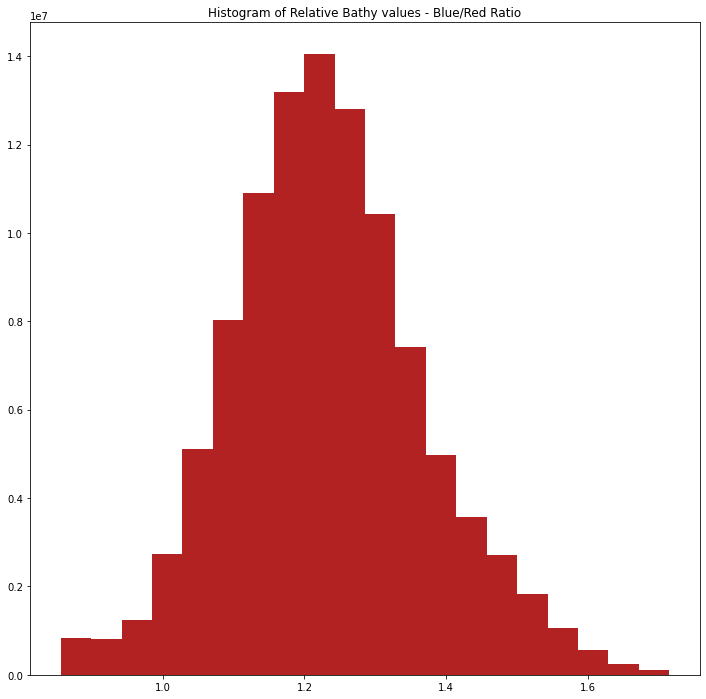

In [9]:
# Histogram - Blue/Red ratio

ep.hist(rb_red_masked, 
        colors = 'firebrick',
        title="Histogram of Relative Bathy values - Blue/Red Ratio",
        hist_range=([rb_red_plot_min, rb_red_plot_max])
       )
plt.show()

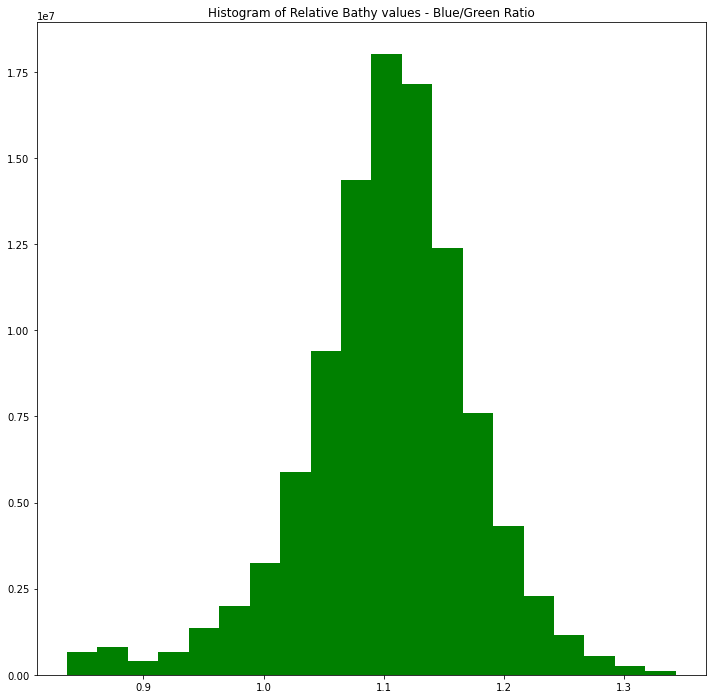

In [10]:
# Histogram - Blue / Green ratio
ep.hist(rb_grn_masked, 
        colors = 'green',
        title="Histogram of Relative Bathy values - Blue/Green Ratio",
        hist_range=([rb_grn_plot_min, rb_grn_plot_max])

       )
plt.show()

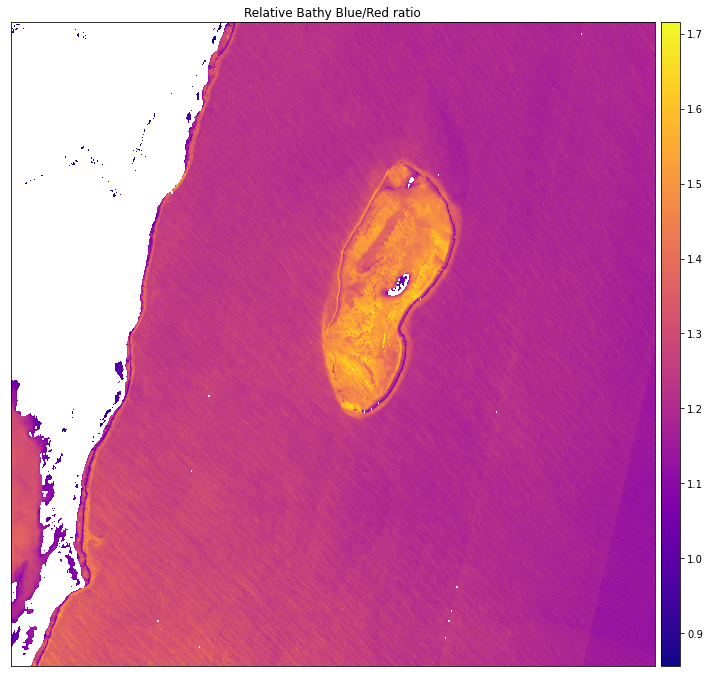

In [11]:
# Plot relative bathy with earthpy - Blue/Red ratio
ep.plot_bands(rb_red_masked, 
              cmap='plasma',
              title="Relative Bathy Blue/Red ratio",
              scale=False,
             vmax=rb_red_plot_max,
             vmin=rb_red_plot_min)
plt.show()

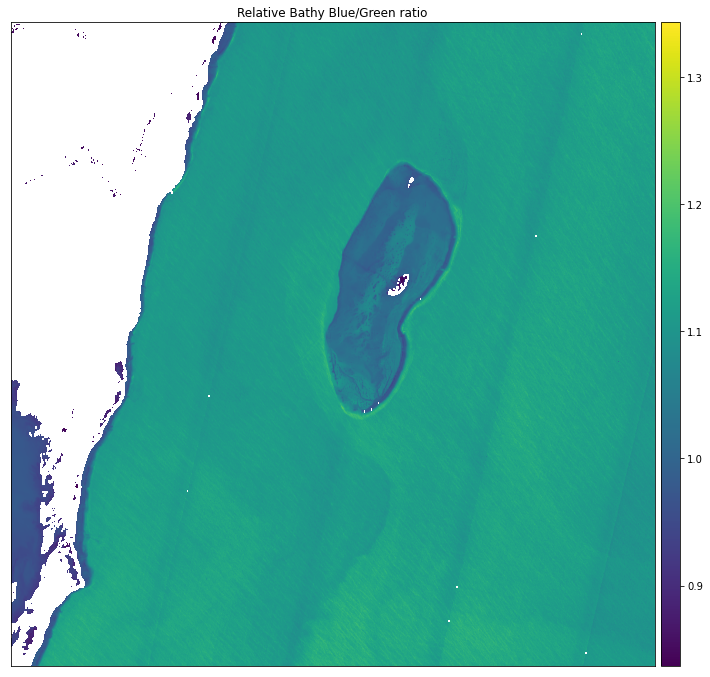

In [12]:
# Plot relative bathy with earthpy - Blue/Green ratio
ep.plot_bands(rb_grn_masked, 
              cmap='viridis',
              title="Relative Bathy Blue/Green ratio",
              scale=False,
             vmax=rb_grn_plot_max,
             vmin=rb_grn_plot_min)
plt.show()

In [26]:
depth_pts = gpd.read_file(depthpts_path)
depth_pts

,id,dep_dig,dep_m,geometry
0,1,18.0,5.49,POINT (458210.884 2036777.167)
1,2,8.0,2.44,POINT (457216.051 2039147.834)
2,3,5.0,1.52,POINT (461971.496 2041412.667)
3,4,12.0,3.66,POINT (457851.051 2042612.111)
4,6,23.0,7.01,POINT (458648.329 2046365.667)
...,...,...,...,...
452,788,4.0,1.22,POINT (411668.985 2010203.834)
453,789,5.0,1.52,POINT (411673.488 2010530.634)
454,790,5.0,1.52,POINT (411959.712 2014794.693)
455,791,5.0,1.52,POINT (411827.144 2014912.005)


In [27]:
# Relative bathy values sampled from raster at sounding point locations  (uses rasterstats)
relbathy_red_pts = point_query(depth_pts, rb_red_masked, 
                           affine=rb_red_profile['transform'], 
                           geojson_out=True,
                           property_name='reldep_red',
                           nodata=-99999
                          )
# print(type(relbathy_red_pts))
relbathy_red_pts  # GeoJSOn object   -- list of GeoJSON objects

[{'id': '0',
  'type': 'Feature',
  'properties': {'dep_dig': 18.0,
   'dep_m': 5.49,
   'id': 1,
   'reldep_red': 1.4783656060890984},
  'geometry': {'type': 'Point',
   'coordinates': (458210.8844489725, 2036777.1669574846)},
  'bbox': (458210.8844489725,
   2036777.1669574846,
   458210.8844489725,
   2036777.1669574846)},
 {'id': '1',
  'type': 'Feature',
  'properties': {'dep_dig': 8.0,
   'dep_m': 2.44,
   'id': 2,
   'reldep_red': 1.4971074637131578},
  'geometry': {'type': 'Point',
   'coordinates': (457216.05111462506, 2039147.8336265713)},
  'bbox': (457216.05111462506,
   2039147.8336265713,
   457216.05111462506,
   2039147.8336265713)},
 {'id': '2',
  'type': 'Feature',
  'properties': {'dep_dig': 5.0,
   'dep_m': 1.52,
   'id': 3,
   'reldep_red': 1.5534925066598348},
  'geometry': {'type': 'Point',
   'coordinates': (461971.4955639203, 2041412.6669622127)},
  'bbox': (461971.4955639203,
   2041412.6669622127,
   461971.4955639203,
   2041412.6669622127)},
 {'id': '3',
  

In [28]:
relbathy_pts = point_query(relbathy_red_pts, rb_grn_masked, 
                           affine=rb_grn_profile['transform'], 
                           geojson_out=True,
                           property_name='reldep_grn',
                           nodata=-99999
                          )
# print(type(relbathy_red_pts))
relbathy_pts  # GeoJSOn object   -- list of GeoJSON objects

[{'id': '0',
  'type': 'Feature',
  'properties': {'dep_dig': 18.0,
   'dep_m': 5.49,
   'id': 1,
   'reldep_red': 1.4783656060890984,
   'reldep_grn': 1.0769115850948399},
  'geometry': {'type': 'Point',
   'coordinates': (458210.8844489725, 2036777.1669574846)},
  'bbox': (458210.8844489725,
   2036777.1669574846,
   458210.8844489725,
   2036777.1669574846)},
 {'id': '1',
  'type': 'Feature',
  'properties': {'dep_dig': 8.0,
   'dep_m': 2.44,
   'id': 2,
   'reldep_red': 1.4971074637131578,
   'reldep_grn': 1.066330127146732},
  'geometry': {'type': 'Point',
   'coordinates': (457216.05111462506, 2039147.8336265713)},
  'bbox': (457216.05111462506,
   2039147.8336265713,
   457216.05111462506,
   2039147.8336265713)},
 {'id': '2',
  'type': 'Feature',
  'properties': {'dep_dig': 5.0,
   'dep_m': 1.52,
   'id': 3,
   'reldep_red': 1.5534925066598348,
   'reldep_grn': 1.0124580557781033},
  'geometry': {'type': 'Point',
   'coordinates': (461971.4955639203, 2041412.6669622127)},
  'bb

In [29]:
# Convert GeoJSON format back to GeoPandas data fram
from geojson import Feature, Point, FeatureCollection
collection = FeatureCollection(relbathy_pts)
depth_relbathy_pts = gpd.GeoDataFrame.from_features(collection['features'])
depth_relbathy_pts

,geometry,dep_dig,dep_m,id,reldep_red,reldep_grn
0,POINT (458210.884 2036777.167),18.0,5.49,1,1.478366,1.076912
1,POINT (457216.051 2039147.834),8.0,2.44,2,1.497107,1.066330
2,POINT (461971.496 2041412.667),5.0,1.52,3,1.553493,1.012458
3,POINT (457851.051 2042612.111),12.0,3.66,4,1.505073,1.028405
4,POINT (458648.329 2046365.667),23.0,7.01,6,1.616273,1.029971
...,...,...,...,...,...,...
452,POINT (411668.985 2010203.834),4.0,1.22,788,1.228707,0.974198
453,POINT (411673.488 2010530.634),5.0,1.52,789,1.281293,0.975195
454,POINT (411959.712 2014794.693),5.0,1.52,790,1.270822,0.975758
455,POINT (411827.144 2014912.005),5.0,1.52,791,1.295664,0.982762


In [30]:
# Remove No Data points
depth_relbathy_pts = depth_relbathy_pts[depth_relbathy_pts['reldep_red'] > 0]
depth_relbathy_pts

,geometry,dep_dig,dep_m,id,reldep_red,reldep_grn
0,POINT (458210.884 2036777.167),18.0,5.49,1,1.478366,1.076912
1,POINT (457216.051 2039147.834),8.0,2.44,2,1.497107,1.066330
2,POINT (461971.496 2041412.667),5.0,1.52,3,1.553493,1.012458
3,POINT (457851.051 2042612.111),12.0,3.66,4,1.505073,1.028405
4,POINT (458648.329 2046365.667),23.0,7.01,6,1.616273,1.029971
...,...,...,...,...,...,...
452,POINT (411668.985 2010203.834),4.0,1.22,788,1.228707,0.974198
453,POINT (411673.488 2010530.634),5.0,1.52,789,1.281293,0.975195
454,POINT (411959.712 2014794.693),5.0,1.52,790,1.270822,0.975758
455,POINT (411827.144 2014912.005),5.0,1.52,791,1.295664,0.982762


In [31]:
# Full data set - Blue/Red Ratio
fig = px.scatter(depth_relbathy_pts, x="reldep_red", y=pt_depth, title="Blue/Red Ratio")
fig.show()

In [32]:
# Full data set - Green/Red Ratio
fig = px.scatter(depth_relbathy_pts, x="reldep_grn", y=pt_depth, title="Blue/Green Ratio")
fig.show()

In [39]:
# Vary maxdepth to plot regression, Blue/Red ratio
min = 0
max = 10

fig = px.scatter(depth_relbathy_pts[(depth_relbathy_pts[pt_depth] >= min) & 
                                    (depth_relbathy_pts[pt_depth] <= max)], 
                                     x="reldep_red", y=pt_depth, trendline="ols",
                                     title="Blue/Red Ratio"
                                    )
fig.show()
# https://www.statsmodels.org/stable/regression.html
results = px.get_trendline_results(fig)
print(results)
regression_params = results.px_fit_results.iloc[0].params
print(regression_params)
results.px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...
[-11.82141448  11.88684666]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     105.3
Date:                Fri, 19 Jun 2020   Prob (F-statistic):           3.02e-21
Time:                        10:15:13   Log-Likelihood:                -645.00
No. Observations:                 288   AIC:                             1294.
Df Residuals:                     286   BIC:                             1301.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.8214      1.507     -7.846      0.000     -14.787      -8.856
x1            11.8868      1.158     10.263      0.000       9.607      14.166
==============================================================================
Omnibus:                       20.628   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.762
Skew:                           0.701   Prob(JB):                     6.92e-06
Kurtosis:                       2.872   Cond. No.                         23.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Vary maxdepth to plot regression, Blue/Green ratio
min = 0
max = 25

fig = px.scatter(depth_relbathy_pts[(depth_relbathy_pts[pt_depth] >= min) & 
                                    (depth_relbathy_pts[pt_depth] <= max)], 
                                     x="reldep_grn", y=pt_depth, trendline="ols",
                                     title="Blue/Green Ratio"
                                    )
fig.show()
# https://www.statsmodels.org/stable/regression.html
results = px.get_trendline_results(fig)
print(results)
regression_params = results.px_fit_results.iloc[0].params
print(regression_params)
results.px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...
[-95.95551986 100.06296858]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1332.
Date:                Fri, 19 Jun 2020   Prob (F-statistic):          4.18e-130
Time:                        10:15:20   Log-Likelihood:                -1057.2
No. Observations:                 407   AIC:                             2118.
Df Residuals:                     405   BIC:                             2126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -95.9555      2.837    -33.824      0.000    -101.532     -90.379
x1           100.0630      2.742     36.492      0.000      94.673     105.453
==============================================================================
Omnibus:                       53.965   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.339
Skew:                           0.768   Prob(JB):                     2.68e-22
Kurtosis:                       4.871   Cond. No.                         35.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""